## Wrangle activity

This jupyter notebook is to be complemented with the files wrangle_act.pdf and act_report.pdf where every step is documented in detail with the steps followed and the conclusions made.

In [1]:
# load packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
import requests
import os
import json
import tweepy

In [2]:
#read csv
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#download file from web
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

if not os.path.exists(url.split('/')[-1]):
    response = requests.get(url)

    with open(os.path.join(url.split('/')[-1]), mode = 'wb') as file: #add encoding
        file.write(response.content)

In [4]:
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [45]:
#twitter api information

f=open('twitter_api_information.txt',"r")
lines=f.readlines()
consumer_key = lines[0]
consumer_secret = lines[1]
access_token = lines[2]
access_secret = lines[3]
f.close()

In [46]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
#api = tweepy.API(auth)

In [47]:
#read retweet and favorite from api by id
if not os.path.exists('tweet_json.txt'):
#create dictionary to build file
    tweet_json = []
    count = 0
    for id in twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(id, tweet_mode='extended')
            retweet_count = tweet.retweet_count
            favorite_count = tweet.favorite_count

            # Append to list of dictionaries
            tweet_json.append({'retweet_count': retweet_count,
                                'favorite_count': favorite_count,
                                'tweet_id': id})
        except tweepy.error.TweepError:
            count += 1
            print(str(count) + ' ' + 'Missing id:' + ' ' + str(id))

    #write twitter_df to a json file
    with open('tweet_json.txt', 'w') as outfile:
        json.dump(tweet_json, outfile)

In [7]:
with open('tweet_json.txt') as json_file:
    tweet_json = json.load(json_file)

In [8]:
tweet_json = pd.DataFrame(tweet_json, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [9]:
#Assess data
#twitter archive
print(twitter_archive.info())
print(twitter_archive.describe())
print(twitter_archive.sample(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
#image predictions
print(image_predictions.info())
print(image_predictions.describe())
print(image_predictions.sample(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None
           tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  

In [11]:
#tweet_json
print(tweet_json.info())
print(tweet_json.describe())
print(tweet_json.sample(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        1813 non-null   int64
 1   retweet_count   1813 non-null   int64
 2   favorite_count  1813 non-null   int64
dtypes: int64(3)
memory usage: 42.6 KB
None
           tweet_id  retweet_count  favorite_count
count  1.813000e+03    1813.000000     1813.000000
mean   7.454719e+17    2566.659680     7639.616106
std    7.016702e+16    4387.271444    11812.643311
min    6.660209e+17       1.000000        0.000000
25%    6.859732e+17     503.000000     1124.000000
50%    7.268282e+17    1163.000000     3293.000000
75%    8.168290e+17    3017.000000     9484.000000
max    8.924206e+17   75113.000000   152026.000000
                tweet_id  retweet_count  favorite_count
1205  696405997980676096           1117            3106
1106  704134088924532736            440            1462
1382  67

In [12]:
#data cleaning
# combine tables into a new one df where we perform cleaning operations
master_clean = twitter_archive.merge(image_predictions, on='tweet_id', how='inner').merge(tweet_json, on='tweet_id', how='inner')

In [13]:
#test
print(master_clean.head())
print(master_clean.info())

             tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  r

In [14]:
#convert timestamp to date type
master_clean['timestamp'] = pd.to_datetime(master_clean.timestamp)

In [15]:
#test
print(master_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1606 non-null   int64              
 1   in_reply_to_status_id       14 non-null     float64            
 2   in_reply_to_user_id         14 non-null     float64            
 3   timestamp                   1606 non-null   datetime64[ns, UTC]
 4   source                      1606 non-null   object             
 5   text                        1606 non-null   object             
 6   retweeted_status_id         47 non-null     float64            
 7   retweeted_status_user_id    47 non-null     float64            
 8   retweeted_status_timestamp  47 non-null     object             
 9   expanded_urls               1606 non-null   object             
 10  rating_numerator            1606 non-null   int64           

In [16]:
#numerator ratings min value
zero_ratings = master_clean.query('rating_numerator == 0')
print(zero_ratings)

               tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
241  835152434251116546                    NaN                  NaN   
642  746906459439529985           7.468859e+17         4.196984e+09   

                    timestamp  \
241 2017-02-24 15:40:31+00:00   
642 2016-06-26 03:22:31+00:00   

                                                source  \
241  <a href="http://twitter.com/download/iphone" r...   
642  <a href="http://twitter.com/download/iphone" r...   

                                                  text  retweeted_status_id  \
241  When you're so blinded by your systematic plag...                  NaN   
642  PUPDATE: can't see any. Even if I could, I cou...                  NaN   

     retweeted_status_user_id retweeted_status_timestamp  \
241                       NaN                        NaN   
642                       NaN                        NaN   

                                         expanded_urls  ...   p1_conf  p1_dog  \
241  https:

In [17]:
#denominator different than 10
non_standard_denominator = master_clean.query('rating_denominator != 10')
print(non_standard_denominator['rating_denominator'].count())

12


In [18]:
#standard denominator 10
master_clean ['rating_numerator']= master_clean['rating_numerator']*10/master_clean['rating_denominator']
master_clean ['rating_denominator']= master_clean['rating_denominator']*10/master_clean['rating_denominator']

In [19]:
#test
non_standard_denominator = master_clean.query('rating_denominator != 10')
print(non_standard_denominator['rating_denominator'].count())

0


In [20]:
#numerator ratings max value
high_ratings = master_clean.query('rating_numerator > 15')
print(high_ratings[['tweet_id', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'retweet_count', 'favorite_count']])

master_clean = master_clean.query('rating_numerator < 15')

                tweet_id                                      expanded_urls  \
426   778027034220126208  https://twitter.com/dog_rates/status/778027034...   
612   749981277374128128  https://twitter.com/dog_rates/status/749981277...   
1328  670842764863651840  https://twitter.com/dog_rates/status/670842764...   

      rating_numerator  rating_denominator     name  retweet_count  \
426               27.0                10.0   Sophie           1576   
612             1776.0                10.0  Atticus           2399   
1328             420.0                10.0     None           8036   

      favorite_count  
426             6477  
612             4993  
1328           23114  


In [21]:
#test
print(master_clean.rating_numerator.max())
print(master_clean.describe()[['rating_numerator', 'rating_denominator']])

14.0
       rating_numerator  rating_denominator
count       1602.000000              1602.0
mean          10.574396                10.0
std            2.211033                 0.0
min            0.000000                10.0
25%           10.000000                10.0
50%           11.000000                10.0
75%           12.000000                10.0
max           14.000000                10.0


In [22]:
#extract source from link in source column
source = []
for s in master_clean.source:
    source_split = s.split('>')[-2].split('<')[-2]
    source.append(source_split)

master_clean['source'] = source
print(master_clean.source.value_counts())

Twitter for iPhone    1567
Twitter Web Client      29
TweetDeck                6
Name: source, dtype: int64


In [23]:
#test
print(master_clean.source.head())

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object


In [24]:
#dog stage column
master_clean['dog_stage'] = master_clean.doggo

master_clean.loc[master_clean['doggo']=='doggo', 'dog_stage'] = 'doggo'
master_clean.loc[master_clean['puppo']=='puppo', 'dog_stage'] = 'puppo'
master_clean.loc[master_clean['floofer']=='floofer', 'dog_stage'] = 'floofer'
master_clean.loc[master_clean['pupper']=='pupper', 'dog_stage'] = 'pupper'

In [25]:
#test
print(master_clean.dog_stage.value_counts())

None       1362
pupper      158
doggo        57
puppo        19
floofer       6
Name: dog_stage, dtype: int64


In [26]:
#extended urls column with duplicated information
#check for duplicated fields
count = 0
for url in master_clean.expanded_urls:
    if len(url.split(',')) > 1:
        if url.split(',')[1] != url.split(',') [-1]:
            count += 1
            print(count)
            print(False)
            print(url)

In [27]:
#split into one entry
urls = []
for url in master_clean.expanded_urls:
    if len(url.split(',')) > 1:
        urls.append(url.split(',')[-1])
    else:
        urls.append(url)

In [28]:
#test
print(urls[0:5])

['https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 'https://twitter.com/dog_rates/status/891815181378084864/photo/1', 'https://twitter.com/dog_rates/status/891689557279858688/photo/1', 'https://twitter.com/dog_rates/status/891327558926688256/photo/1']


In [29]:
#dog names duplicated values
print(master_clean.name.value_counts().head())
print(master_clean[master_clean.name == "a"]['text'])

None       428
a           48
Oliver       9
Charlie      9
Tucker       8
Name: name, dtype: int64
50      Here is a pupper approaching maximum borkdrive...
459     Guys this is getting so out of hand. We only r...
632     This is a mighty rare blue-tailed hammer sherk...
634     Viewer discretion is advised. This is a terrib...
643     This is a carrot. We only rate dogs. Please on...
669     This is a very rare Great Alaskan Bush Pupper....
805     People please. This is a Deadly Mediterranean ...
815     This is a taco. We only rate dogs. Please only...
932     Here is a heartbreaking scene of an incredible...
941     Here is a whole flock of puppers.  60/50 I'll ...
951     This is a Butternut Cumberfloof. It's not wind...
957     This is a Wild Tuscan Poofwiggle. Careful not ...
969     "Pupper is a present to world. Here is a bow f...
1072    This is a rare Arctic Wubberfloof. Unamused by...
1179    This is a Sagitariot Baklava mix. Loves her ne...
1196    This is a heavily opin

In [30]:
#identify text with "We only rate dogs." comment
only_dogs = master_clean[master_clean['text'].str.contains('We only rate dogs.')]
print(only_dogs[['rating_numerator', 'name', 'retweet_count', 'favorite_count', 'text']])

      rating_numerator          name  retweet_count  favorite_count  \
24                12.0          None           5262           28090   
53                12.0          None           3378           19513   
79                12.0          None           3544           20937   
104               12.0          None           3775           22502   
108               13.0          None           7128           29914   
115               14.0          None           7895           30060   
126               13.0          None          21130           69262   
138               12.0         quite          27727           84329   
175               12.0          None           7190           29223   
179               12.0          None           4120           24297   
194               12.0          None           4606           24425   
240               12.0          None           5589           25635   
301               11.0          None           2553           13088   
318   

In [31]:
#drop rows without dogs
master_clean = master_clean[~master_clean.text.str.contains('We only rate dogs.')]

In [32]:
#test
only_dogs = master_clean[master_clean['text'].str.contains('We only rate dogs.')]
print(only_dogs[['rating_numerator', 'name', 'retweet_count', 'favorite_count', 'text']])

Empty DataFrame
Columns: [rating_numerator, name, retweet_count, favorite_count, text]
Index: []


In [33]:
#zero favorites fields
zero_fav = master_clean.query('favorite_count == 0')
for i in zero_fav.text:
    print(i)

RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5
RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G
RT @rachaeleasler: these @dog_rates hats are 13/10 bean approved https://t.co/nRCdq4g9gG
RT @tallylott: h*ckin adorable promposal. 13/10 @dog_rates https://t.co/6n8hzNihJ9
RT @eddie_coe98: Thanks @dog_rates completed my laptop. 10/10 would buy again https://t.co/bO0rThDlXI
RT @basic_vacek_: I love my new mug easy 13/10 @dog_rates https://t.co/0bYtoL7Wwt
RT @dog_rates: This is Ken. His cheeks are magic. 13/10 (IG: ken_shiba) https://t.co/btzf1zTDeQ
RT @alexmartindawg: THE DRINK IS DR. PUPPER 10/10 good pun @matt___nelson @GoodDogsGame https://t.co/act3duiqbL
RT @EmilieGambril: 12/10 h*cking excited about my new shirt! @dog_rates https://t.co/zFEfMTaHqU
RT @dog_rates: This is Moreton. He's the Good Boy Who Lived. 13/10 magical as h*ck 

In [34]:
#zero retweet fields
zero_rt = master_clean.query('retweet_count == 0')
print(zero_rt)

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog, retweet_count, favorite_count, dog_stage]
Index: []

[0 rows x 31 columns]


In [35]:
#save master clean to csv file
master_clean.to_csv('twitter_archive_master.csv')

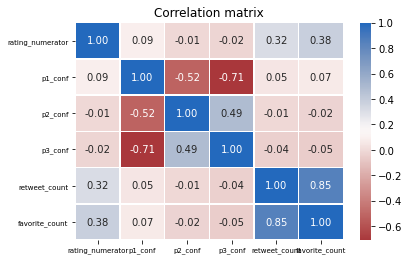

In [36]:
#data exploration
# correlation matrix
numeric_vars = ['rating_numerator', 'p1_conf', 'p2_conf', 'p3_conf', 'retweet_count', 'favorite_count']

sb.heatmap(master_clean[numeric_vars].corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', linewidths=.5 )
plt.title('Correlation matrix')
plt.xticks(fontsize=7, rotation=0)
plt.yticks(fontsize=7)
plt.show()

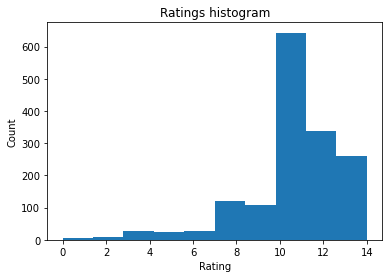

In [37]:
#rating univariate exploration
plt.hist(data = master_clean, x ='rating_numerator')
plt.title('Ratings histogram')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

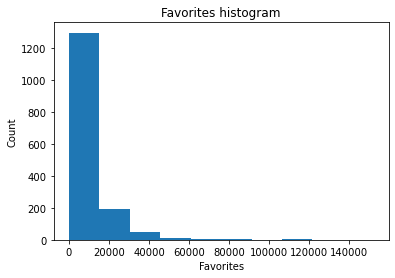

In [38]:
#favorite counts univariate exploration
plt.hist(data = master_clean, x ='favorite_count')
plt.title('Favorites histogram')
plt.xlabel('Favorites')
plt.ylabel('Count')
plt.show()

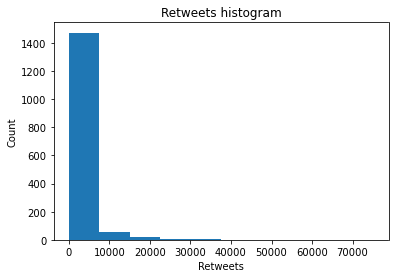

In [39]:
#retweet counts univariate exploration
plt.hist(data = master_clean, x ='retweet_count')
plt.title('Retweets histogram')
plt.xlabel('Retweets')
plt.ylabel('Count')
plt.show()

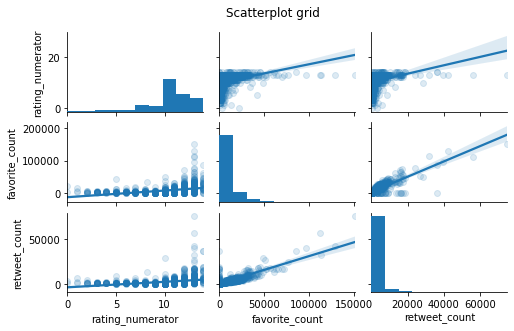

In [40]:
#ratings, retweets and favorites scatterplot
scatter_vars = ['rating_numerator', 'favorite_count', 'retweet_count']

g = sb.PairGrid(data = master_clean, vars = scatter_vars, height = 1.5, aspect = 1.5)
g = g.map_diag(plt.hist);
g.map_offdiag(sb.regplot, scatter_kws={'alpha':0.15})
plt.subplots_adjust(top=0.9)
plt.suptitle("Scatterplot grid")
plt.show()

In [41]:
#ratings by dog breed
breeds = master_clean.groupby('p1').agg(count=('rating_numerator', 'size'), mean_rating=('rating_numerator', 'mean')).reset_index()
breeds = breeds.sort_values('count', ascending=False)

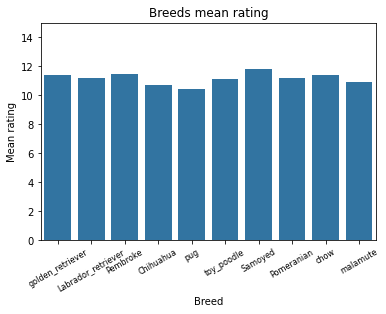

In [42]:
#plot top ten count breeds
breeds_top_ten = breeds.iloc[0:10,:]

base_color = sb.color_palette()[0]
sb.barplot(y='mean_rating', x='p1', data=breeds_top_ten, color = base_color)
plt.xticks(rotation=30, size=8)  # Set text labels.
plt.ylim(0, 15)
plt.title('Breeds mean rating')
plt.xlabel('Breed')
plt.ylabel('Mean rating')
plt.show()

In [43]:
#ratings, favorites and retweets
#three variable heatmap
#create bins
master_clean['favorites_bin'] = pd.qcut(master_clean['favorite_count'], 10)
master_clean['retweets_bin'] = pd.qcut(master_clean['retweet_count'], 10)

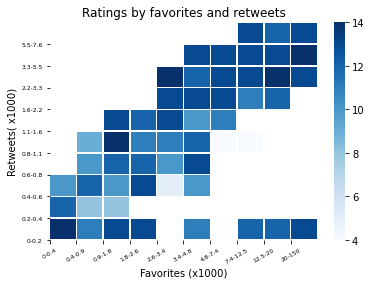

In [44]:
#plot
master_clean.drop_duplicates(['favorites_bin','retweets_bin'], inplace=True)
data_pivoted = master_clean.pivot('favorites_bin', 'retweets_bin', 'rating_numerator')
ax = sb.heatmap(data_pivoted, cmap="Blues", linewidths=.5)
plt.title('Ratings by favorites and retweets')
ax.invert_yaxis()
plt.yticks(size=6)
plt.xticks(np.arange(10), ['0-0.4', '0.4-0.9', '0.9-1.8', '1.8-2.6', '2.6-3.4', '3.4-4.8', '4.8-7.4', '7.4-12.5', '12.5-20', '20-150'])  # Set text labels.
plt.xticks(rotation=30, size=6)
plt.yticks(np.arange(10), ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.1', '1.1-1.6', '1.6-2.2', '2.2-3.3', '3.3-5.5', '5.5-7.6'])  # Set text labels.
plt.xlabel('Favorites (x1000)', size = 10)
plt.ylabel('Retweets( x1000)', size = 10)
plt.show()